In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Problem in Statsmodel

In [2]:
import statsmodels.api as sm

In [3]:
X = np.array([[1, 2], [3, 4]])

In [4]:
X

array([[1, 2],
       [3, 4]])

In [5]:
sm.add_constant(X)

array([[1., 1., 2.],
       [1., 3., 4.]])

In [6]:
Y = np.array([[1]])

In [7]:
Y

array([[1]])

In [8]:
sm.add_constant(Y)

array([[1]])

In [9]:
bias = np.ones(Y.shape[0])
Y = np.column_stack([bias, Y])

In [10]:
Y

array([[1., 1.]])

## Continuous Piecewise Linear

In [11]:
def find_beta(features, response):
    X = features
    y = response
    return np.linalg.pinv(X) @ y

def relu(x, xi):
    return np.maximum(x-xi, 0)

def rss(y, y_hat):
    return np.sum((y - y_hat)**2)

In [12]:
def gen_features(x, nodes):
    bias = np.ones(x.shape[0])
    X = np.column_stack([bias, x])                         # [1 | x]
    bases = np.column_stack([relu(x, xi) for xi in nodes]) # [(x-xi_1) | (x-xi_2) | ... ]
    return np.column_stack([X, bases])

In [13]:
def continuous_piecewise_linear(data, nodes):
    X = gen_features(data[:,0], nodes)
    y = data[:,1]
    
    # OLS
    beta = find_beta(X, y)

    def cpl(x, nodes=nodes):
        X2 = gen_features(x, nodes)
        y = X2 @ beta

        return y

    return cpl

In [22]:
x = np.arange(0, 10, 0.1)
y = np.sin(x) + 0.1 * np.random.randn(len(x))
data = np.column_stack([x, y])

nodes = np.arange(1, 10, 1)

cpl = continuous_piecewise_linear(data, nodes)

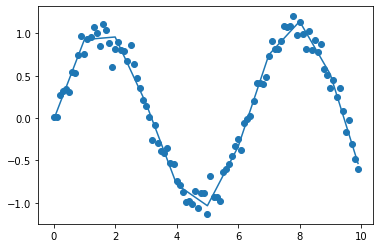

In [23]:
plt.scatter(x, y)
plt.plot(x, cpl(x))

## Adaptive CPL

### Separate Data

In [90]:
new_nodes = np.empty((len(nodes)+1, 2))
new_nodes[0] = (0, nodes[0])
new_nodes[-1] = (nodes[-1], 10)
for i in range(1, len(nodes)):
    new_nodes[i] = (nodes[i-1], nodes[i])

In [91]:
new_nodes

array([[ 0.,  1.],
       [ 1.,  2.],
       [ 2.,  3.],
       [ 3.,  4.],
       [ 4.,  5.],
       [ 5.,  6.],
       [ 6.,  7.],
       [ 7.,  8.],
       [ 8.,  9.],
       [ 9., 10.]])

In [92]:
splitted_data = []
for (a, b) in new_nodes:
    splitted_data.append( data[(data[:,0] >= a) & (data[:,0] < b), :] )

In [93]:
rss_vec = np.empty(len(new_nodes))

for (i, spd) in enumerate(splitted_data):
    rss_vec[i] = rss(cpl(spd[:,0]), spd[:,1])

In [94]:
rss_vec

array([0.07029391, 0.21957807, 0.13946216, 0.12484506, 0.08168505,
       0.1612294 , 0.08567109, 0.08610227, 0.11153215, 0.10740752])

In [95]:
mean_rss = np.mean(rss_vec)
mean_rss

0.11878066759933684

In [96]:
np.where(rss_vec > mean_rss)[0]

array([1, 2, 3, 5])

In [97]:
idx = np.where(rss_vec > mean_rss)[0]

In [98]:
offset = 1

for i in idx:
    (a,b) = new_nodes[i+offset-1]
    (a,b,c) = np.linspace(a, b, 3)
    new_nodes[i+offset-1] = (a,b)
    new_nodes = np.insert(new_nodes, i+offset, (b, c), axis=0)
    offset += 1

In [99]:
new_nodes

array([[ 0. ,  1. ],
       [ 1. ,  1.5],
       [ 1.5,  2. ],
       [ 2. ,  2.5],
       [ 2.5,  3. ],
       [ 3. ,  3.5],
       [ 3.5,  4. ],
       [ 4. ,  5. ],
       [ 5. ,  5.5],
       [ 5.5,  6. ],
       [ 6. ,  7. ],
       [ 7. ,  8. ],
       [ 8. ,  9. ],
       [ 9. , 10. ]])

In [100]:
splitted_data2 = []
for (a, b) in new_nodes:
    splitted_data2.append( data[(data[:,0] >= a) & (data[:,0] < b), :] )

In [101]:
cpl = continuous_piecewise_linear(data, new_nodes[1:,0])
rss_vec2 = np.empty(len(new_nodes))

for (i, spd) in enumerate(splitted_data2):
    rss_vec2[i] = rss(cpl(spd[:,0]), spd[:,1])

In [102]:
rss_vec2

array([0.07272811, 0.02770234, 0.10921907, 0.02864618, 0.00560143,
       0.04459957, 0.05032366, 0.08514725, 0.13776576, 0.01631704,
       0.08614178, 0.08760059, 0.1119267 , 0.10740869])

In [103]:
idx = np.where(rss_vec2 > mean_rss)[0]

In [104]:
idx

array([8])

In [106]:
while len(idx) > 0:
    offset = 1

    for i in idx:
        (a,b) = new_nodes[i+offset-1]
        (a,b,c) = np.linspace(a, b, 3)
        new_nodes[i+offset-1] = (a,b)
        new_nodes = np.insert(new_nodes, i+offset, (b, c), axis=0)
        offset += 1
    
    splitted_data = []
    for (a, b) in new_nodes:
        splitted_data.append( data[(data[:,0] >= a) & (data[:,0] < b), :] )
    
    cpl = continuous_piecewise_linear(data, new_nodes[1:,0])
    rss_vec = np.empty(len(new_nodes))

    for (i, spd) in enumerate(splitted_data):
        rss_vec[i] = rss(cpl(spd[:,0]), spd[:,1])
        
    idx = np.where(rss_vec > mean_rss)[0]

In [107]:
new_nodes

array([[ 0.  ,  1.  ],
       [ 1.  ,  1.5 ],
       [ 1.5 ,  2.  ],
       [ 2.  ,  2.5 ],
       [ 2.5 ,  3.  ],
       [ 3.  ,  3.5 ],
       [ 3.5 ,  4.  ],
       [ 4.  ,  5.  ],
       [ 5.  ,  5.25],
       [ 5.25,  5.5 ],
       [ 5.5 ,  6.  ],
       [ 6.  ,  7.  ],
       [ 7.  ,  8.  ],
       [ 8.  ,  9.  ],
       [ 9.  , 10.  ]])

In [111]:
new_nodes[1:, 0]

array([1.  , 1.5 , 2.  , 2.5 , 3.  , 3.5 , 4.  , 5.  , 5.25, 5.5 , 6.  ,
       7.  , 8.  , 9.  ])

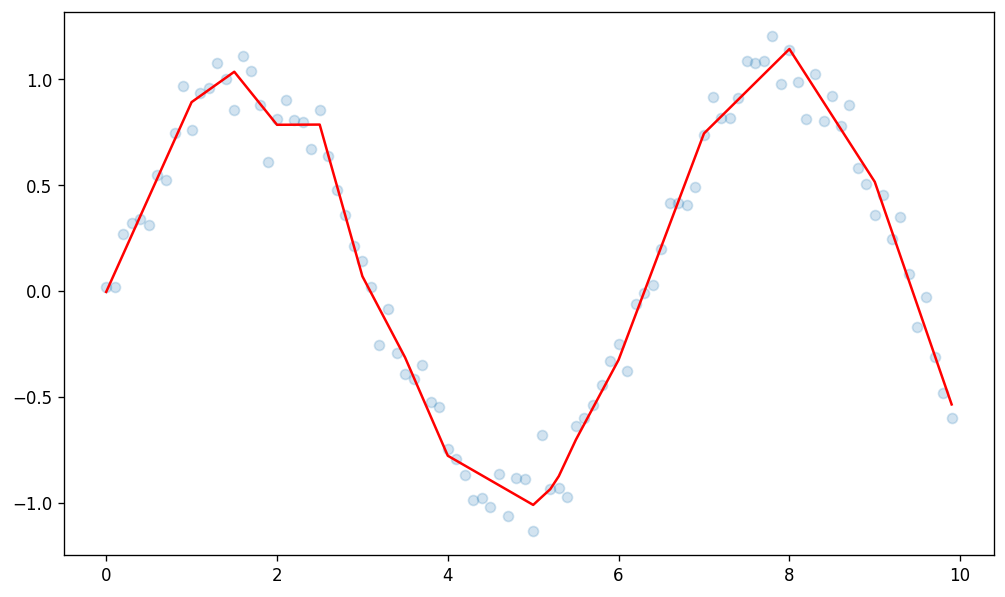

In [112]:
plt.figure(figsize=(10, 6), dpi=120)
plt.scatter(x, y, alpha=0.2)
plt.plot(x, cpl(x), color='red')
plt.show()